[01_feature_engineering](https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/04_alpha_factor_research/01_feature_engineering.ipynb)

In [39]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [41]:
DATA_STORE = "../data/assets.h5"
START = 2000
END = 2018
with pd.HDFStore(DATA_STORE) as store:
    prices = store["quandl/wiki/prices"].loc[idx[str(START) : str(END), :], "adj_close"].unstack("ticker")
    stocks = store["us_equities/stocks"].loc[:, ["marketcap", "ipoyear", "sector"]]

In [42]:
temp_df = pd.HDFStore(DATA_STORE)
temp_df

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets.h5

In [43]:
temp_df["us_equities/stocks"]

,name,lastsale,marketcap,ipoyear,sector,industry
ticker,,,,,,
PIH,"1347 Property Insurance Holdings, Inc.",7.2001,4.309000e+07,2014.0,Finance,Property-Casualty Insurers
PIHPP,"1347 Property Insurance Holdings, Inc.",25.6200,NaN,NaN,Finance,Property-Casualty Insurers
TURN,180 Degree Capital Corp.,2.2600,7.033000e+07,NaN,Finance,Finance/Investors Services
FLWS,"1-800 FLOWERS.COM, Inc.",12.9000,8.333900e+08,1999.0,Consumer Services,Other Specialty Stores
FCCY,1st Constitution Bancorp (NJ),21.3000,1.781400e+08,NaN,Finance,Savings Institutions
...,...,...,...,...,...,...
ZOES,"Zoe&#39;s Kitchen, Inc.",10.0700,1.974000e+08,2014.0,Consumer Services,Restaurants
ZTS,Zoetis Inc.,86.0700,4.165000e+10,2013.0,Health Care,Major Pharmaceuticals
ZTO,ZTO Express (Cayman) Inc.,20.2200,1.434000e+10,2016.0,Transportation,Trucking Freight/Courier Services


In [44]:
temp_df = temp_df["quandl/wiki/prices"]
temp_df

open    high     low   close      volume  ex-dividend  \
date       ticker                                                            
1962-01-02 ARNC     65.56   65.75   65.38   65.38      5600.0          0.0   
           BA       50.88   50.88   50.00   50.00     11595.0          0.0   
           CAT      38.50   38.87   38.12   38.50     13600.0          0.0   
           DD      241.50  244.25  241.50  241.50      2000.0          0.0   
           DIS      37.25   38.50   37.25   37.25      2098.0          0.0   
...                   ...     ...     ...     ...         ...          ...   
2018-03-27 ZIXI      4.43    4.45    4.35    4.39    207304.0          0.0   
           ZNGA      3.85    3.85    3.68    3.70  11026010.0          0.0   
           ZOES     15.13   15.24   14.75   14.88    261242.0          0.0   
           ZTS      84.08   84.45   81.21   81.86   2676191.0          0.0   
           ZUMZ     24.65   24.65   23.35   23.60    403884.0          0.0   

                   split_ratio   adj_open   adj_high    adj_low  adj_close  \
date       ticker                                                            
1962-01-02 ARNC            1.0   3.458163   3.468185   3.448668   3.448668   
           BA              1.0   0.887160   0.887160   0.871816   0.871816   
           CAT             1.0   1.578370   1.593539   1.562791   1.578370   
           DD              1.0   4.718414   4.772144   4.718414   4.718414   
           DIS             1.0   0.141259   0.145999   0.141259   0.141259   
...                        ...        ...        ...        ...        ...   
2018-03-27 ZIXI            1.0   4.430000   4.450000   4.350000   4.390000   
           ZNGA            1.0   3.850000   3.850000   3.680000   3.700000   
           ZOES            1.0  15.130000  15.240000  14.750000  14.880000   
           ZTS             1.0  84.080000  84.450000  81.210000  81.860000   
           ZUMZ            1.0  24.650000  24.650000  23.350000  23.600000   

                     adj_volume  
date       ticker                
1962-01-02 ARNC    4.480000e+04  
           BA      3.521981e+05  
           CAT     1.632000e+05  
           DD      3.600000e+04  
           DIS     4.088582e+05  
...                         ...  
2018-03-27 ZIXI    2.073040e+05  
           ZNGA    1.102601e+07  
           ZOES    2.612420e+05  
           ZTS     2.676191e+06  
           ZUMZ    4.038840e+05  

[15389314 rows x 12 columns]

In [45]:
temp_df = temp_df.loc[idx[str(START) : str(END), :], "adj_close"]
temp_df

date        ticker
2000-01-03  A         49.121329
            AAN        4.975857
            AAON       1.025920
            AAPL       3.596463
            ABAX       7.063984
                        ...    
2018-03-27  ZIXI       4.390000
            ZNGA       3.700000
            ZOES      14.880000
            ZTS       81.860000
            ZUMZ      23.600000
Name: adj_close, Length: 11343920, dtype: float64

In [46]:
temp_df = temp_df.unstack("ticker")
temp_df

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,37.06,23.5,NaN,NaN,NaN,NaN,3.7025,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,36.50,22.5,NaN,NaN,NaN,NaN,3.5475,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,37.13,23.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,35.25,22.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,38.00,21.5,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,69.400000,47.95,54.09,60.80,47.370000,26.71,39.050000,115.24,171.270000,32.46,...,4.28,4.53,NaN,NaN,NaN,3.94,15.66,NaN,84.10,23.95
2018-03-22,67.470000,44.92,52.31,60.18,45.940000,25.96,38.550000,111.71,168.845000,32.52,...,4.19,4.52,NaN,NaN,NaN,3.81,15.27,NaN,82.06,23.35
2018-03-23,66.060000,44.71,51.01,58.35,45.300000,25.36,37.200000,110.84,164.940000,31.78,...,4.05,4.40,NaN,NaN,NaN,3.80,15.12,NaN,80.60,23.55


In [47]:
del temp_df

In [48]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [49]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


In [50]:
stocks

,marketcap,ipoyear,sector
ticker,,,
PIH,4.309000e+07,2014.0,Finance
PIHPP,NaN,NaN,Finance
TURN,7.033000e+07,NaN,Finance
FLWS,8.333900e+08,1999.0,Consumer Services
FCCY,1.781400e+08,NaN,Finance
...,...,...,...
ZOES,1.974000e+08,2014.0,Consumer Services
ZTS,4.165000e+10,2013.0,Health Care
ZTO,1.434000e+10,2016.0,Transportation


## Keep data with stock info

In [51]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

In [52]:
shared = prices.columns.intersection(stocks.index)

In [53]:
shared

Index(['A', 'AA', 'AAL', 'AAMC', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT',
       ...
       'ZEN', 'ZEUS', 'ZGNX', 'ZION', 'ZIOP', 'ZIXI', 'ZNGA', 'ZOES', 'ZTS',
       'ZUMZ'],
      dtype='object', name='ticker', length=2412)

In [54]:
stocks = stocks.loc[shared, :]
stocks

,marketcap,ipoyear,sector
ticker,,,
A,1.960000e+10,1999.0,Capital Goods
AA,8.540000e+09,2016.0,Basic Industries
AAL,1.767000e+10,NaN,Transportation
AAMC,1.104900e+08,NaN,Finance
AAN,3.200000e+09,NaN,Technology
...,...,...,...
ZIXI,2.944800e+08,NaN,Technology
ZNGA,3.550000e+09,2011.0,Technology
ZOES,1.974000e+08,2014.0,Consumer Services


In [55]:
prices = prices.loc[:, shared]
prices

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,4.466544,NaN,43.826745,NaN,37.06,NaN,NaN,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,4.466544,NaN,41.702530,NaN,36.50,NaN,NaN,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,4.408079,NaN,41.899948,NaN,37.13,NaN,NaN,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,4.350542,NaN,42.247403,NaN,35.25,NaN,NaN,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,4.640083,NaN,42.350060,NaN,38.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,69.400000,47.95,54.09,60.80,47.370000,26.71,39.050000,115.24,171.270000,32.46,...,48.89,22.120000,42.10,55.100000,4.28,4.53,3.94,15.66,84.10,23.95
2018-03-22,67.470000,44.92,52.31,60.18,45.940000,25.96,38.550000,111.71,168.845000,32.52,...,48.12,20.650000,41.05,53.070000,4.19,4.52,3.81,15.27,82.06,23.35
2018-03-23,66.060000,44.71,51.01,58.35,45.300000,25.36,37.200000,110.84,164.940000,31.78,...,46.70,20.000000,40.35,51.230000,4.05,4.40,3.80,15.12,80.60,23.55


In [56]:
prices.shape[1] == stocks.shape[0]

True

## Create monthly return series

In [57]:
monthly_prices = prices.resample('M').last()
monthly_prices

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,45.157511,NaN,NaN,NaN,4.766882,NaN,1.211345,NaN,3.333330,NaN,...,NaN,4.176075,NaN,46.927728,NaN,30.88,NaN,NaN,NaN,NaN
2000-02-29,70.884807,NaN,NaN,NaN,4.941969,NaN,1.296459,NaN,3.682567,NaN,...,NaN,4.176075,NaN,42.110354,NaN,53.78,NaN,NaN,NaN,NaN
2000-03-31,70.953031,NaN,NaN,NaN,4.834658,NaN,1.334456,NaN,4.363369,NaN,...,NaN,3.712067,NaN,33.039089,NaN,72.81,NaN,NaN,NaN,NaN
2000-04-30,60.466992,NaN,NaN,NaN,4.360229,NaN,1.595875,NaN,3.985860,NaN,...,NaN,4.408079,NaN,32.935916,NaN,36.94,NaN,NaN,NaN,NaN
2000-05-31,50.233382,NaN,NaN,NaN,4.312221,NaN,1.852735,NaN,2.698793,NaN,...,NaN,4.118538,NaN,36.732135,NaN,28.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30,69.240000,41.51,50.49,72.0000,37.720000,43.66,36.450000,101.00,171.850000,39.36,...,33.61,19.920000,38.85,49.550000,4.570,4.40,4.100,15.98,72.29,21.800
2017-12-31,66.970000,53.87,52.03,81.6000,39.850000,37.82,36.700000,99.69,169.230000,38.24,...,33.84,21.490000,40.05,50.830000,4.140,4.38,4.000,16.72,72.04,20.825
2018-01-31,73.430000,52.02,54.32,69.0241,40.890000,32.39,36.400000,116.99,167.430000,35.26,...,38.52,23.310000,36.30,54.030000,3.945,4.23,3.585,14.72,76.73,20.750


In [58]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f"return_{lag}m"] = (
        monthly_prices.pct_change(lag)
        .stack()
        .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1 - outlier_cutoff)))
        .add(1)
        .pow(1 / lag)
        .sub(1)
    )

In [59]:
temp_df = monthly_prices.pct_change(1)
temp_df

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,0.569724,NaN,NaN,NaN,0.036730,NaN,0.070263,NaN,0.104771,NaN,...,NaN,0.000000,NaN,-0.102655,NaN,0.741580,NaN,NaN,NaN,NaN
2000-03-31,0.000962,NaN,NaN,NaN,-0.021714,NaN,0.029308,NaN,0.184872,NaN,...,NaN,-0.111111,NaN,-0.215417,NaN,0.353849,NaN,NaN,NaN,NaN
2000-04-30,-0.147788,NaN,NaN,NaN,-0.098131,NaN,0.195900,NaN,-0.086518,NaN,...,NaN,0.187500,NaN,-0.003123,NaN,-0.492652,NaN,NaN,NaN,NaN
2000-05-31,-0.169243,NaN,NaN,NaN,-0.011010,NaN,0.160952,NaN,-0.322908,NaN,...,NaN,-0.065684,NaN,0.115261,NaN,-0.242014,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30,0.017786,-0.131226,0.078385,-0.146667,0.025000,0.071674,0.041429,0.235625,0.016623,0.014695,...,0.084194,0.055085,0.036000,0.066509,-0.019313,-0.092784,0.051282,0.301303,0.132717,0.235127
2017-12-31,-0.032785,0.297760,0.030501,0.133333,0.056469,-0.133761,0.006859,-0.012970,-0.015246,-0.028455,...,0.006843,0.078815,0.030888,0.025832,-0.094092,-0.004545,-0.024390,0.046308,-0.003458,-0.044725
2018-01-31,0.096461,-0.034342,0.044013,-0.154116,0.026098,-0.143575,-0.008174,0.173538,-0.010636,-0.077929,...,0.138298,0.084691,-0.093633,0.062955,-0.047101,-0.034247,-0.103750,-0.119617,0.065103,-0.003601


In [60]:
temp_df = temp_df.stack()
temp_df

date        ticker
2000-02-29  A         0.569724
            AAN       0.036730
            AAON      0.070263
            AAPL      0.104771
            ABAX     -0.007631
                        ...   
2018-03-31  ZIXI      0.083951
            ZNGA      0.069364
            ZOES      0.000000
            ZTS       0.012367
            ZUMZ      0.197970
Length: 425983, dtype: float64

[quantile](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html)

In [61]:
import numpy as np

df = pd.DataFrame(np.array([[1, 1], [2, 10], [3, 100], [4, 200]]), columns=["a", "b"])
df.quantile([0.1, 1, .6, .8, .9])

,a,b
0.1,1.3,3.7
1.0,4.0,200.0
0.6,2.8,82.0
0.8,3.4,140.0
0.9,3.7,170.0


In [62]:
1 + (4 - 1) * 0.6

2.8

[clip](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html)

In [63]:
temp_df

date        ticker
2000-02-29  A         0.569724
            AAN       0.036730
            AAON      0.070263
            AAPL      0.104771
            ABAX     -0.007631
                        ...   
2018-03-31  ZIXI      0.083951
            ZNGA      0.069364
            ZOES      0.000000
            ZTS       0.012367
            ZUMZ      0.197970
Length: 425983, dtype: float64

In [64]:
temp_df = temp_df.pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1 - outlier_cutoff)))
temp_df

date        ticker
2000-02-29  A         0.430943
            AAN       0.036730
            AAON      0.070263
            AAPL      0.104771
            ABAX     -0.007631
                        ...   
2018-03-31  ZIXI      0.083951
            ZNGA      0.069364
            ZOES      0.000000
            ZTS       0.012367
            ZUMZ      0.197970
Length: 425983, dtype: float64

In [65]:
temp_df = temp_df.add(1)
temp_df

date        ticker
2000-02-29  A         1.430943
            AAN       1.036730
            AAON      1.070263
            AAPL      1.104771
            ABAX      0.992369
                        ...   
2018-03-31  ZIXI      1.083951
            ZNGA      1.069364
            ZOES      1.000000
            ZTS       1.012367
            ZUMZ      1.197970
Length: 425983, dtype: float64

In [66]:
temp_df = temp_df.pow(1/2)
temp_df

date        ticker
2000-02-29  A         1.196220
            AAN       1.018199
            AAON      1.034535
            AAPL      1.051081
            ABAX      0.996177
                        ...   
2018-03-31  ZIXI      1.041129
            ZNGA      1.034101
            ZOES      1.000000
            ZTS       1.006165
            ZUMZ      1.094518
Length: 425983, dtype: float64

In [67]:
temp_df = temp_df.sub(1)
temp_df

date        ticker
2000-02-29  A         0.196220
            AAN       0.018199
            AAON      0.034535
            AAPL      0.051081
            ABAX     -0.003823
                        ...   
2018-03-31  ZIXI      0.041129
            ZNGA      0.034101
            ZOES      0.000000
            ZTS       0.006165
            ZUMZ      0.094518
Length: 425983, dtype: float64

In [68]:
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2000-02-29 A        0.430943        NaN        NaN        NaN        NaN   
           AAN      0.036730        NaN        NaN        NaN        NaN   
           AAON     0.070263        NaN        NaN        NaN        NaN   
           AAPL     0.104771        NaN        NaN        NaN        NaN   
           ABAX    -0.007631        NaN        NaN        NaN        NaN   
...                      ...        ...        ...        ...        ...   
2018-03-31 ZIXI     0.083951   0.018737   0.000760  -0.017817  -0.028409   
           ZNGA     0.069364   0.015912  -0.025652  -0.003559   0.001818   
           ZOES     0.000000   0.005420  -0.038117   0.027701   0.025046   
           ZTS      0.012367   0.032888   0.043517   0.042527   0.030657   
           ZUMZ     0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m  
date       ticker              
2000-02-29 A              NaN  
           AAN            NaN  
           AAON           NaN  
           AAPL           NaN  
           ABAX           NaN  
...                       ...  
2018-03-31 ZIXI     -0.007585  
           ZNGA      0.021989  
           ZOES     -0.017982  
           ZTS       0.036608  
           ZUMZ      0.021422  

[425983 rows x 6 columns]

In [69]:
data.swaplevel()

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
ticker,date,,,,,,
A,2000-02-29,0.430943,NaN,NaN,NaN,NaN,NaN
AAN,2000-02-29,0.036730,NaN,NaN,NaN,NaN,NaN
AAON,2000-02-29,0.070263,NaN,NaN,NaN,NaN,NaN
AAPL,2000-02-29,0.104771,NaN,NaN,NaN,NaN,NaN
ABAX,2000-02-29,-0.007631,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
ZIXI,2018-03-31,0.083951,0.018737,0.000760,-0.017817,-0.028409,-0.007585
ZNGA,2018-03-31,0.069364,0.015912,-0.025652,-0.003559,0.001818,0.021989
ZOES,2018-03-31,0.000000,0.005420,-0.038117,0.027701,0.025046,-0.017982


In [70]:
data = data.swaplevel().dropna()
data

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
ticker,date,,,,,,
A,2001-01-31,-0.003653,0.022360,0.056104,0.049811,-0.052500,-0.015988
AAN,2001-01-31,0.116071,0.008439,-0.015687,-0.009856,-0.002912,-0.009572
AAON,2001-01-31,0.300170,0.034296,0.028670,-0.006238,0.010159,0.031027
AAPL,2001-01-31,0.430943,0.144685,0.033941,-0.132736,-0.110514,-0.070339
ABAX,2001-01-31,-0.073762,-0.042573,-0.044914,-0.003738,-0.028353,-0.031993
...,...,...,...,...,...,...,...
ZIXI,2018-03-31,0.083951,0.018737,0.000760,-0.017817,-0.028409,-0.007585
ZNGA,2018-03-31,0.069364,0.015912,-0.025652,-0.003559,0.001818,0.021989
ZOES,2018-03-31,0.000000,0.005420,-0.038117,0.027701,0.025046,-0.017982


## Drop stocks with less than 10 yrs of returns

In [71]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [72]:
nobs

ticker
A       207
AA        5
AAL     139
AAMC     52
AAN     207
       ... 
ZIXI    207
ZNGA     64
ZOES     36
ZTS      50
ZUMZ    143
Length: 2399, dtype: int64

In [73]:
keep

Index(['A', 'AAL', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAWW', 'ABAX', 'ABC', 'ABCB',
       ...
       'YORW', 'YRCW', 'YUM', 'ZBH', 'ZBRA', 'ZEUS', 'ZION', 'ZIOP', 'ZIXI',
       'ZUMZ'],
      dtype='object', name='ticker', length=1838)

In [74]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000
mean,0.012255,0.009213,0.008181,0.007025,0.006552,0.006296
std,0.114236,0.081170,0.066584,0.048474,0.039897,0.034792
min,-0.329564,-0.255452,-0.214783,-0.162063,-0.131996,-0.114283
25%,-0.046464,-0.030716,-0.023961,-0.014922,-0.011182,-0.009064
50%,0.009448,0.009748,0.009744,0.009378,0.008982,0.008726
75%,0.066000,0.049249,0.042069,0.031971,0.027183,0.024615
max,0.430943,0.281819,0.221789,0.154555,0.124718,0.106371


In [75]:
data.corr('spearman')

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
return_1m,1.000000,0.651836,0.517255,0.360704,0.287663,0.243793
return_2m,0.651836,1.000000,0.767705,0.520103,0.406012,0.343362
return_3m,0.517255,0.767705,1.000000,0.653041,0.505323,0.426459
return_6m,0.360704,0.520103,0.653041,1.000000,0.765310,0.632684
return_9m,0.287663,0.406012,0.505323,0.765310,1.000000,0.820091
return_12m,0.243793,0.343362,0.426459,0.632684,0.820091,1.000000


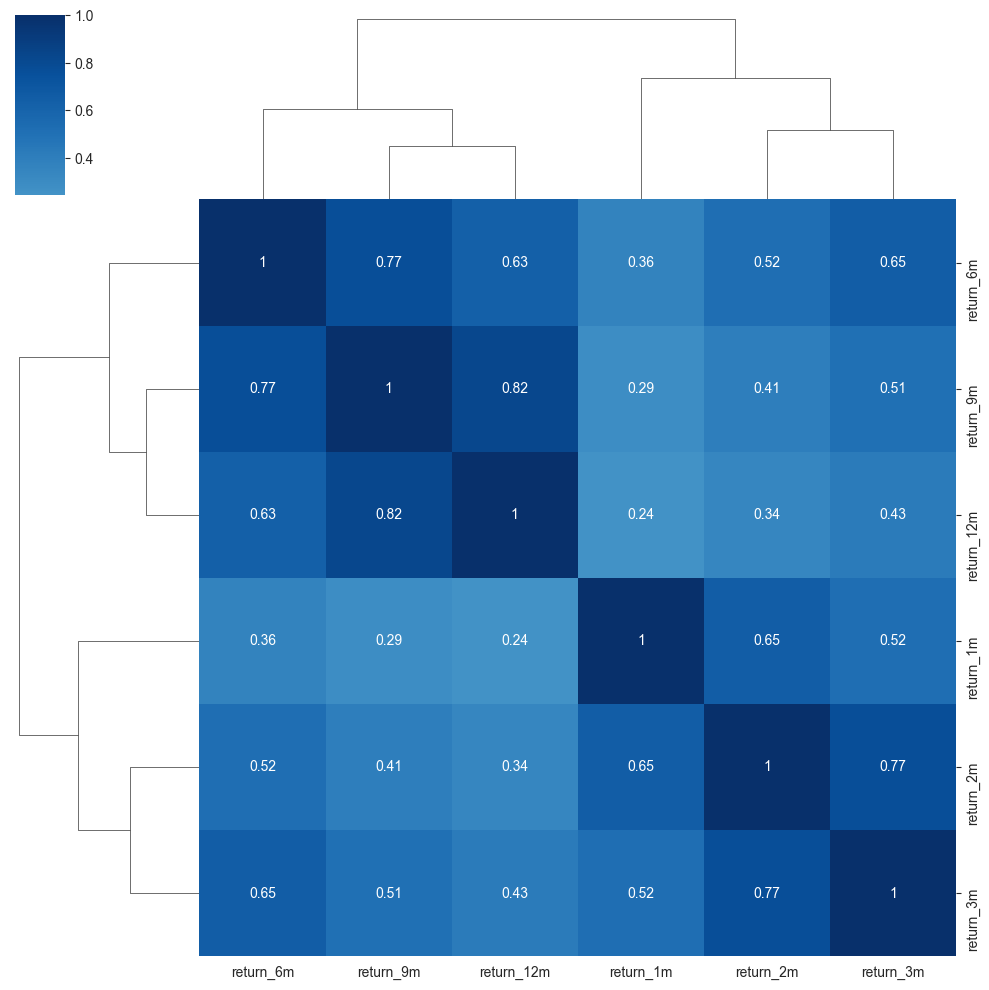

In [76]:
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues')

## Rolling Factor Betas

In [77]:
factors = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]
factor_data = web.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start="2000-01-31",
    end="2021-02-28",
)[
    0
].drop("RF", axis=1)
factor_data.index = factor_data.index.to_timestamp()

In [78]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2000-01-01,-4.74,4.42,-1.88,-6.29,4.72
2000-02-01,2.45,18.28,-9.59,-18.65,-0.48
2000-03-01,5.20,-15.32,8.13,11.79,-1.59
2000-04-01,-6.40,-5.01,7.26,7.66,5.65
2000-05-01,-4.42,-3.81,4.75,4.13,1.37
...,...,...,...,...,...
2020-10-01,-2.10,4.64,4.25,-0.83,-0.78
2020-11-01,12.47,7.11,2.09,-2.20,1.40
2020-12-01,4.63,4.79,-1.51,-1.96,-0.12


In [79]:
factor_data = factor_data.resample("M").last().div(100)
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2000-01-31,-0.0474,0.0442,-0.0188,-0.0629,0.0472
2000-02-29,0.0245,0.1828,-0.0959,-0.1865,-0.0048
2000-03-31,0.0520,-0.1532,0.0813,0.1179,-0.0159
2000-04-30,-0.0640,-0.0501,0.0726,0.0766,0.0565
2000-05-31,-0.0442,-0.0381,0.0475,0.0413,0.0137
...,...,...,...,...,...
2020-10-31,-0.0210,0.0464,0.0425,-0.0083,-0.0078
2020-11-30,0.1247,0.0711,0.0209,-0.0220,0.0140
2020-12-31,0.0463,0.0479,-0.0151,-0.0196,-0.0012


In [80]:
factor_data.index.name = "date"
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2000-01-31,-0.0474,0.0442,-0.0188,-0.0629,0.0472
2000-02-29,0.0245,0.1828,-0.0959,-0.1865,-0.0048
2000-03-31,0.0520,-0.1532,0.0813,0.1179,-0.0159
2000-04-30,-0.0640,-0.0501,0.0726,0.0766,0.0565
2000-05-31,-0.0442,-0.0381,0.0475,0.0413,0.0137
...,...,...,...,...,...
2020-10-31,-0.0210,0.0464,0.0425,-0.0083,-0.0078
2020-11-30,0.1247,0.0711,0.0209,-0.0220,0.0140
2020-12-31,0.0463,0.0479,-0.0151,-0.0196,-0.0012


In [81]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
ticker date                                                         
A      2001-01-31  0.0313  0.0548 -0.0507 -0.0469 -0.0503  -0.003653
       2001-02-28 -0.1005  0.0283  0.1247  0.0910  0.0907  -0.329564
       2001-03-31 -0.0726  0.0233  0.0642  0.0335  0.0392  -0.146389
       2001-04-30  0.0794 -0.0086 -0.0467 -0.0306 -0.0320   0.269444
       2001-05-31  0.0072  0.0360  0.0336  0.0025  0.0191  -0.140220
...                   ...     ...     ...     ...     ...        ...
ZUMZ   2017-11-30  0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.235127
       2017-12-31  0.0106 -0.0107  0.0006  0.0074  0.0169  -0.044725
       2018-01-31  0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.003601
       2018-02-28 -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.050602
       2018-03-31 -0.0235  0.0359 -0.0021 -0.0046  0.0001   0.197970

[360752 rows x 6 columns]

## [Rolling OLS](https://www.statsmodels.org/stable/generated/statsmodels.regression.rolling.RollingOLS.html)

In [82]:
T = 24
betas = factor_data.groupby(level="ticker", group_keys=False).apply(
    lambda x: RollingOLS(
        endog=x.return_1m,
        exog=sm.add_constant(x.drop("return_1m", axis=1)),
        window=min(T, x.shape[0] - 1),
    )
    .fit(params_only=True)
    .params.drop("const", axis=1)
)

In [83]:
betas

Mkt-RF       SMB       HML       RMW       CMA
ticker date                                                        
A      2001-01-31       NaN       NaN       NaN       NaN       NaN
       2001-02-28       NaN       NaN       NaN       NaN       NaN
       2001-03-31       NaN       NaN       NaN       NaN       NaN
       2001-04-30       NaN       NaN       NaN       NaN       NaN
       2001-05-31       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
ZUMZ   2017-11-30 -0.775796  1.327020  1.336272  3.474425  0.982165
       2017-12-31 -0.970033  1.658541  1.531017  3.655010  0.334506
       2018-01-31  0.065406  1.156550  1.321246  2.979204  0.647188
       2018-02-28  0.326675  1.020393  1.345950  2.712224  0.680867
       2018-03-31  0.224885  1.651891  1.167755  2.936886  0.541205

[360752 rows x 5 columns]

In [84]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000,360752.000000
mean,0.979365,0.626588,0.122610,-0.062073,0.016754,1.485997
std,0.918116,1.254249,1.603524,1.908446,2.158982,3.306487
min,-9.805604,-10.407516,-15.382504,-23.159702,-18.406854,-33.499590
25%,0.463725,-0.118767,-0.707780,-0.973586,-1.071697,0.000000
50%,0.928902,0.541623,0.095292,0.037585,0.040641,1.213499
75%,1.444882,1.304325,0.946760,0.950267,1.135600,3.147199
max,10.855709,10.297453,15.038572,17.079472,16.671709,34.259432


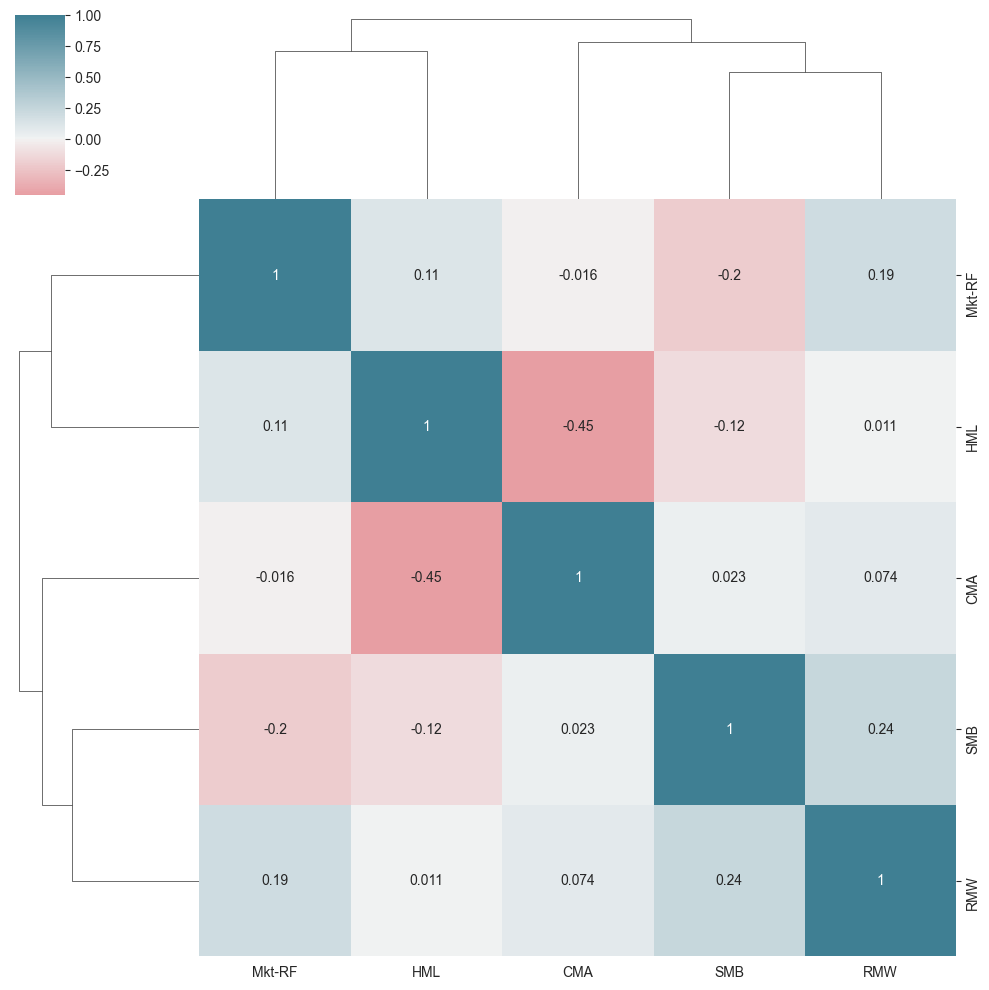

In [85]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0)

In [98]:
betas.groupby(level="ticker").shift()

Mkt-RF       SMB       HML       RMW       CMA
ticker date                                                        
A      2001-01-31       NaN       NaN       NaN       NaN       NaN
       2001-02-28       NaN       NaN       NaN       NaN       NaN
       2001-03-31       NaN       NaN       NaN       NaN       NaN
       2001-04-30       NaN       NaN       NaN       NaN       NaN
       2001-05-31       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
ZUMZ   2017-11-30 -0.775796  1.327020  1.336272  3.474425  0.982165
       2017-12-31 -0.970033  1.658541  1.531017  3.655010  0.334506
       2018-01-31  0.065406  1.156550  1.321246  2.979204  0.647188
       2018-02-28  0.326675  1.020393  1.345950  2.712224  0.680867
       2018-03-31  0.224885  1.651891  1.167755  2.936886  0.541205

[360752 rows x 5 columns]

In [87]:
data = data.join(betas.groupby(level="ticker").shift())
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988       NaN       NaN       NaN       NaN   
       2001-02-28   -0.084537       NaN       NaN       NaN       NaN   
       2001-03-31   -0.096606       NaN       NaN       NaN       NaN   
       2001-04-30   -0.066102       NaN       NaN       NaN       NaN   
       2001-05-31   -0.063425       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224   

                        CMA  
ticker date                  
A      2001-01-31       NaN  
       2001-02-28       NaN  
       2001-03-31       NaN  
       2001-04-30       NaN  
       2001-05-31       NaN  
...                     ...  
ZUMZ   2017-11-30  1.257435  
       2017-12-31  0.982165  
       2018-01-31  0.334506  
       2018-02-28  0.647188  
       2018-03-31  0.680867  

[360752 rows x 11 columns]

## Impute mean for missing factor betas

In [99]:
data.loc[:, factors] = data[factors].apply(lambda x: x.fillna(x.mean()))
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  0.979296  0.626560  0.122390 -0.062500   
       2001-02-28   -0.084537  0.979296  0.626560  0.122390 -0.062500   
       2001-03-31   -0.096606  0.979296  0.626560  0.122390 -0.062500   
       2001-04-30   -0.066102  0.979296  0.626560  0.122390 -0.062500   
       2001-05-31   -0.063425  0.979296  0.626560  0.122390 -0.062500   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224   

                        CMA  
ticker date                  
A      2001-01-31  0.016772  
       2001-02-28  0.016772  
       2001-03-31  0.016772  
       2001-04-30  0.016772  
       2001-05-31  0.016772  
...                     ...  
ZUMZ   2017-11-30  1.257435  
       2017-12-31  0.982165  
       2018-01-31  0.334506  
       2018-02-28  0.647188  
       2018-03-31  0.680867  

[360752 rows x 11 columns]

## Momentum factors
We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [100]:
for lag in [2, 3, 6, 9, 12]:
    data[f"momentum_{lag}"] = data[f"return_{lag}m"].sub(data.return_1m)
data[f"momentum_3_12"] = data[f"return_12m"].sub(data.return_3m)

In [101]:
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  0.979296  0.626560  0.122390 -0.062500   
       2001-02-28   -0.084537  0.979296  0.626560  0.122390 -0.062500   
       2001-03-31   -0.096606  0.979296  0.626560  0.122390 -0.062500   
       2001-04-30   -0.066102  0.979296  0.626560  0.122390 -0.062500   
       2001-05-31   -0.063425  0.979296  0.626560  0.122390 -0.062500   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224   

                        CMA  momentum_2  momentum_3  momentum_6  momentum_9  \
ticker date                                                                   
A      2001-01-31  0.016772    0.026013    0.059757    0.053464   -0.048847   
       2001-02-28  0.016772    0.140448    0.213128    0.245423    0.253138   
       2001-03-31  0.016772   -0.103054   -0.028727    0.071761    0.053699   
       2001-04-30  0.016772   -0.228477   -0.375191   -0.297629   -0.274280   
       2001-05-31  0.016772    0.184941    0.116903    0.069178    0.075921   
...                     ...         ...         ...         ...         ...   
ZUMZ   2017-11-30  1.257435   -0.137667   -0.029826   -0.161698   -0.227725   
       2017-12-31  0.982165    0.130951    0.092582    0.135712    0.059190   
       2018-01-31  0.334506   -0.020778    0.059019    0.088866    0.019838   
       2018-02-28  0.647188    0.023217    0.017402    0.130086    0.087242   
       2018-03-31  0.680867   -0.131504   -0.155390   -0.152755   -0.123363   

                   momentum_12  momentum_3_12  
ticker date                                    
A      2001-01-31    -0.012335      -0.072092  
       2001-02-28     0.245026       0.031898  
       2001-03-31     0.049783       0.078511  
       2001-04-30    -0.335545       0.039645  
       2001-05-31     0.076795      -0.040108  
...                        ...            ...  
ZUMZ   2017-11-30    -0.245814      -0.215989  
       2017-12-31     0.040729      -0.051853  
       2018-01-31     0.006465      -0.052554  
       2018-02-28     0.047697       0.030295  
       2018-03-31    -0.176548      -0.021157  

[360752 rows x 17 columns]

## Date Indicators

In [102]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  0.979296  0.626560  0.122390 -0.062500   
       2001-02-28   -0.084537  0.979296  0.626560  0.122390 -0.062500   
       2001-03-31   -0.096606  0.979296  0.626560  0.122390 -0.062500   
       2001-04-30   -0.066102  0.979296  0.626560  0.122390 -0.062500   
       2001-05-31   -0.063425  0.979296  0.626560  0.122390 -0.062500   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224   

                        CMA  momentum_2  momentum_3  momentum_6  momentum_9  \
ticker date                                                                   
A      2001-01-31  0.016772    0.026013    0.059757    0.053464   -0.048847   
       2001-02-28  0.016772    0.140448    0.213128    0.245423    0.253138   
       2001-03-31  0.016772   -0.103054   -0.028727    0.071761    0.053699   
       2001-04-30  0.016772   -0.228477   -0.375191   -0.297629   -0.274280   
       2001-05-31  0.016772    0.184941    0.116903    0.069178    0.075921   
...                     ...         ...         ...         ...         ...   
ZUMZ   2017-11-30  1.257435   -0.137667   -0.029826   -0.161698   -0.227725   
       2017-12-31  0.982165    0.130951    0.092582    0.135712    0.059190   
       2018-01-31  0.334506   -0.020778    0.059019    0.088866    0.019838   
       2018-02-28  0.647188    0.023217    0.017402    0.130086    0.087242   
       2018-03-31  0.680867   -0.131504   -0.155390   -0.152755   -0.123363   

                   momentum_12  momentum_3_12  year  month  
ticker date                                                 
A      2001-01-31    -0.012335      -0.072092  2001      1  
       2001-02-28     0.245026       0.031898  2001      2  
       2001-03-31     0.049783       0.078511  2001      3  
       2001-04-30    -0.335545       0.039645  2001      4  
       2001-05-31     0.076795      -0.040108  2001      5  
...                        ...            ...   ...    ...  
ZUMZ   2017-11-30    -0.245814      -0.215989  2017     11  
       2017-12-31     0.040729      -0.051853  2017     12  
       2018-01-31     0.006465      -0.052554  2018      1  
       2018-02-28     0.047697       0.030295  2018      2  
       2018-03-31    -0.176548      -0.021157  2018      3  

[360752 rows x 19 columns]

## Lagged returns

In [103]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-02-28   -0.084537  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-03-31   -0.096606  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-04-30   -0.066102  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-05-31   -0.063425  0.979296  0.626560  0.122390 -0.062500  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556  ...   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425  ...   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010  ...   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204  ...   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224  ...   

                   momentum_12  momentum_3_12  year  month  return_1m_t-1  \
ticker date                                                                 
A      2001-01-31    -0.012335      -0.072092  2001      1            NaN   
       2001-02-28     0.245026       0.031898  2001      2      -0.003653   
       2001-03-31     0.049783       0.078511  2001      3      -0.329564   
       2001-04-30    -0.335545       0.039645  2001      4      -0.146389   
       2001-05-31     0.076795      -0.040108  2001      5       0.269444   
...                        ...            ...   ...    ...            ...   
ZUMZ   2017-11-30    -0.245814      -0.215989  2017     11      -0.024862   
       2017-12-31     0.040729      -0.051853  2017     12       0.235127   
       2018-01-31     0.006465      -0.052554  2018      1      -0.044725   
       2018-02-28     0.047697       0.030295  2018      2      -0.003601   
       2018-03-31    -0.176548      -0.021157  2018      3      -0.050602   

                   return_1m_t-2  return_1m_t-3  return_1m_t-4  return_1m_t-5  \
ticker date                                                                     
A      2001-01-31            NaN            NaN            NaN            NaN   
       2001-02-28            NaN            NaN            NaN            NaN   
       2001-03-31      -0.003653            NaN            NaN            NaN   
       2001-04-30      -0.329564      -0.003653            NaN            NaN   
       2001-05-31      -0.146389      -0.329564      -0.003653            NaN   
...                          ...            ...            ...            ...   
ZUMZ   2017-11-30       0.430943      -0.019685       0.028340      -0.133333   
       2017-12-31      -0.024862       0.430943      -0.019685       0.028340   
       2018-01-31       0.235127      -0.024862       0.430943      -0.019685   
       2018-02-28      -0.044725       0.235127      -0.024862       0.430943   
       2018-03-31      -0.003601      -0.

## Target: Holding Period Returns

In [104]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-02-28   -0.084537  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-03-31   -0.096606  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-04-30   -0.066102  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-05-31   -0.063425  0.979296  0.626560  0.122390 -0.062500  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556  ...   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425  ...   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010  ...   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204  ...   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224  ...   

                   return_1m_t-2  return_1m_t-3  return_1m_t-4  return_1m_t-5  \
ticker date                                                                     
A      2001-01-31            NaN            NaN            NaN            NaN   
       2001-02-28            NaN            NaN            NaN            NaN   
       2001-03-31      -0.003653            NaN            NaN            NaN   
       2001-04-30      -0.329564      -0.003653            NaN            NaN   
       2001-05-31      -0.146389      -0.329564      -0.003653            NaN   
...                          ...            ...            ...            ...   
ZUMZ   2017-11-30       0.430943      -0.019685       0.028340      -0.133333   
       2017-12-31      -0.024862       0.430943      -0.019685       0.028340   
       2018-01-31       0.235127      -0.024862       0.430943      -0.019685   
       2018-02-28      -0.044725       0.235127      -0.024862       0.430943   
       2018-03-31      -0.003601      -0.044725       0.235127      -0.024862   

                   return_1m_t-6  target_1m  target_2m  target_3m  target_6m  \
ticker date                                                                    
A      2001-01-31            NaN  -0.329564  -0.249443  -0.105747  -0.101978   
       2001-02-28            NaN  -0.146389   0.040966  -0.023317  -0.049781   
       2001-03-31            NaN   0.269444   0.044721   0.018842  -0.072607   
       2001-04-30            NaN  -0.140220  -0.087246  -0.098192  -0.089198   
       2001-05-31            NaN  -0.031008  -0.076414  -0.075527  -0.033904   
...                          ...        ...        ...        ...        ...   
ZUMZ   2017-11-30      -0.206128  -0.044725  -0.024380  -0.033200        NaN   
       2017-12-31      -0.133333  -0.003601  -0.027386   0.042579        NaN   
       2018-01-31       0.028340  -0.050602   0.066466        NaN        NaN   
       2018-02-28      -0.019685   0.197970        NaN        NaN        NaN   
 

In [105]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.329564      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.329564  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

## Create age proxy
[qcut](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html)

In [106]:
pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6))).astype(float).fillna(0).astype(int).to_frame("age")

,age
ticker,
A,2
AA,5
AAL,0
AAMC,0
AAN,0
...,...
ZIXI,0
ZNGA,4
ZOES,5


In [107]:
stocks.ipoyear

ticker
A       1999.0
AA      2016.0
AAL        NaN
AAMC       NaN
AAN        NaN
         ...  
ZIXI       NaN
ZNGA    2011.0
ZOES    2014.0
ZTS     2013.0
ZUMZ    2005.0
Name: ipoyear, Length: 2412, dtype: float64

In [108]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-02-28   -0.084537  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-03-31   -0.096606  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-04-30   -0.066102  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-05-31   -0.063425  0.979296  0.626560  0.122390 -0.062500  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556  ...   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425  ...   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010  ...   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204  ...   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224  ...   

                   return_1m_t-3  return_1m_t-4  return_1m_t-5  return_1m_t-6  \
ticker date                                                                     
A      2001-01-31            NaN            NaN            NaN            NaN   
       2001-02-28            NaN            NaN            NaN            NaN   
       2001-03-31            NaN            NaN            NaN            NaN   
       2001-04-30      -0.003653            NaN            NaN            NaN   
       2001-05-31      -0.329564      -0.003653            NaN            NaN   
...                          ...            ...            ...            ...   
ZUMZ   2017-11-30      -0.019685       0.028340      -0.133333      -0.206128   
       2017-12-31       0.430943      -0.019685       0.028340      -0.133333   
       2018-01-31      -0.024862       0.430943      -0.019685       0.028340   
       2018-02-28       0.235127      -0.024862       0.430943      -0.019685   
       2018-03-31      -0.044725       0.235127      -0.024862       0.430943   

                   target_1m  target_2m  target_3m  target_6m  target_12m  age  
ticker date                                                                     
A      2001-01-31  -0.329564  -0.249443  -0.105747  -0.101978   -0.047686    2  
       2001-02-28  -0.146389   0.040966  -0.023317  -0.049781   -0.011986    2  
       2001-03-31   0.269444   0.044721   0.018842  -0.072607    0.010805    2  
       2001-04-30  -0.140220  -0.087246  -0.098192  -0.089198   -0.021512    2  
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.033904   -0.019843    2  
...                      ...        ...        ...        ...         ...  ...  
ZUMZ   2017-11-30  -0.044725  -0.024380  -0.033200        NaN         NaN    3  
       2017-12-31  -0.003601  -0.027386   0.042579        NaN         NaN    3  
       2018-01-31  -0.050602   0.066466        NaN        NaN         NaN    3  
       2018-02-28   0.197970        NaN        NaN        NaN         

## Create dynamic size proxy

In [109]:
size_factor = (
    monthly_prices.loc[data.index.get_level_values("date").unique(), data.index.get_level_values("ticker").unique()]
    .sort_index(ascending=False)
    .pct_change()
    .fillna(0)
    .add(1)
    .cumprod()
)
size_factor

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-02-28,1.023731,1.065815,1.017393,0.967105,0.993392,1.058097,1.030483,0.955842,1.132722,1.012381,...,0.912338,1.024677,0.970196,1.071626,1.019784,1.112593,1.056709,0.920988,0.922551,0.834746
2018-01-31,1.095970,1.067191,0.900264,0.957895,1.017216,0.994594,0.952583,1.027240,1.186406,1.020000,...,1.027597,1.876616,1.008464,1.171829,0.909198,1.151111,1.038639,0.974074,0.963554,0.879237
2017-12-31,0.999552,1.022200,0.877367,0.965789,0.866794,1.005287,0.993226,0.709964,1.092965,0.918095,...,1.100649,1.689777,0.972938,1.112371,0.766278,1.061235,0.977124,1.022222,0.997722,0.882415
2017-11-30,1.033433,0.991945,0.830471,0.959211,0.878185,1.020851,0.977985,0.698781,1.009642,0.944762,...,1.206169,1.447709,0.995112,1.079462,0.814410,0.983704,0.952518,1.128395,1.002278,0.923729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-05-31,0.341528,1.072518,0.099870,0.044896,0.118576,0.007615,0.585097,0.081291,0.143071,0.133726,...,0.159492,16303.937720,0.071803,0.250196,0.147743,0.184687,0.842713,3.950617,2.211845,0.543008
2001-04-30,0.397227,1.072518,0.098187,0.037997,0.118576,0.009730,0.585097,0.063871,0.133873,0.130464,...,0.156495,15593.955347,0.070420,0.250196,0.141936,0.116861,0.826400,3.950617,2.842825,0.543008
2001-03-31,0.312914,1.072518,0.096628,0.038757,0.118576,0.008424,0.585097,0.067936,0.121602,0.133959,...,0.161490,14648.737955,0.060003,0.250196,0.125105,0.106000,0.807791,3.950617,1.601595,0.543008


In [111]:
monthly_prices.loc[
    data.index.get_level_values("date").unique(), data.index.get_level_values("ticker").unique()
].sort_index(ascending=False).pct_change().fillna(0).add(1)

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-02-28,1.023731,1.065815,1.017393,0.967105,0.993392,1.058097,1.030483,0.955842,1.132722,1.012381,...,0.912338,1.024677,0.970196,1.071626,1.019784,1.112593,1.056709,0.920988,0.922551,0.834746
2018-01-31,1.070564,1.001290,0.884873,0.990476,1.023982,0.939984,0.924404,1.074696,1.047394,1.007526,...,1.126335,1.831422,1.039445,1.093505,0.891559,1.034621,0.982900,1.057641,1.044444,1.053299
2017-12-31,0.912025,0.957842,0.974566,1.008242,0.852124,1.010751,1.042667,0.691137,0.921240,0.900093,...,1.071090,0.900438,0.964771,0.949261,0.842806,0.921922,0.940774,1.049430,1.035461,1.003614
2017-11-30,1.033896,0.970402,0.946550,0.993188,1.013141,1.015482,0.984655,0.984249,0.923764,1.029046,...,1.095870,0.856745,1.022791,0.970415,1.062813,0.926943,0.974818,1.103865,1.004566,1.046819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-05-31,1.032000,1.000000,1.008192,0.865125,1.000000,0.858065,1.000000,1.142315,1.042638,1.018585,...,0.957632,1.004215,1.041002,1.000000,0.916735,1.020253,0.917627,1.000000,1.061202,1.000000
2001-04-30,1.163089,1.000000,0.983146,0.846325,1.000000,1.277694,1.000000,0.785714,0.935713,0.975610,...,0.981211,0.956453,0.980744,1.000000,0.960693,0.632754,0.980643,1.000000,1.285273,1.000000
2001-03-31,0.787747,1.000000,0.984127,1.020000,1.000000,0.865830,1.000000,1.063636,0.908333,1.026786,...,1.031915,0.939386,0.852075,1.000000,0.881415,0.907059,0.977482,1.000000,0.563381,1.000000


In [112]:
msize = (size_factor.mul(stocks.loc[size_factor.columns, "marketcap"])).dropna(axis=1, how="all")

In [116]:
stocks

,marketcap,ipoyear,sector
ticker,,,
A,1.960000e+10,1999.0,Capital Goods
AA,8.540000e+09,2016.0,Basic Industries
AAL,1.767000e+10,NaN,Transportation
AAMC,1.104900e+08,NaN,Finance
AAN,3.200000e+09,NaN,Technology
...,...,...,...
ZIXI,2.944800e+08,NaN,Technology
ZNGA,3.550000e+09,2011.0,Technology
ZOES,1.974000e+08,2014.0,Consumer Services


In [115]:
size_factor

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-02-28,1.023731,1.065815,1.017393,0.967105,0.993392,1.058097,1.030483,0.955842,1.132722,1.012381,...,0.912338,1.024677,0.970196,1.071626,1.019784,1.112593,1.056709,0.920988,0.922551,0.834746
2018-01-31,1.095970,1.067191,0.900264,0.957895,1.017216,0.994594,0.952583,1.027240,1.186406,1.020000,...,1.027597,1.876616,1.008464,1.171829,0.909198,1.151111,1.038639,0.974074,0.963554,0.879237
2017-12-31,0.999552,1.022200,0.877367,0.965789,0.866794,1.005287,0.993226,0.709964,1.092965,0.918095,...,1.100649,1.689777,0.972938,1.112371,0.766278,1.061235,0.977124,1.022222,0.997722,0.882415
2017-11-30,1.033433,0.991945,0.830471,0.959211,0.878185,1.020851,0.977985,0.698781,1.009642,0.944762,...,1.206169,1.447709,0.995112,1.079462,0.814410,0.983704,0.952518,1.128395,1.002278,0.923729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-05-31,0.341528,1.072518,0.099870,0.044896,0.118576,0.007615,0.585097,0.081291,0.143071,0.133726,...,0.159492,16303.937720,0.071803,0.250196,0.147743,0.184687,0.842713,3.950617,2.211845,0.543008
2001-04-30,0.397227,1.072518,0.098187,0.037997,0.118576,0.009730,0.585097,0.063871,0.133873,0.130464,...,0.156495,15593.955347,0.070420,0.250196,0.141936,0.116861,0.826400,3.950617,2.842825,0.543008
2001-03-31,0.312914,1.072518,0.096628,0.038757,0.118576,0.008424,0.585097,0.067936,0.121602,0.133959,...,0.161490,14648.737955,0.060003,0.250196,0.125105,0.106000,0.807791,3.950617,1.601595,0.543008


In [114]:
size_factor.columns

Index(['A', 'AAL', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAWW', 'ABAX', 'ABC', 'ABCB',
       ...
       'YORW', 'YRCW', 'YUM', 'ZBH', 'ZBRA', 'ZEUS', 'ZION', 'ZIOP', 'ZIXI',
       'ZUMZ'],
      dtype='object', name='ticker', length=1838)

In [117]:
msize

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.960000e+10,1.767000e+10,3.200000e+09,1.810000e+09,9.990000e+09,9.039900e+11,1.830000e+09,1.900000e+09,1.905000e+10,2.160000e+09,...,4.268100e+08,3.429500e+08,2.516000e+10,2.275000e+10,7.920000e+09,2.295400e+08,1.032000e+10,4.357400e+08,2.944800e+08,6.316500e+08
2018-02-28,2.006513e+10,1.883296e+10,3.255658e+09,1.750461e+09,9.923985e+09,9.565088e+11,1.885783e+09,1.816100e+09,2.157836e+10,2.186743e+09,...,3.893948e+08,3.514129e+08,2.441012e+10,2.437949e+10,8.076693e+09,2.553845e+08,1.090524e+10,4.013112e+08,2.716729e+08,5.272672e+08
2018-01-31,2.148101e+10,1.885726e+10,2.880845e+09,1.733789e+09,1.016199e+10,8.991033e+11,1.743226e+09,1.951756e+09,2.260104e+10,2.203200e+09,...,4.385888e+08,6.435854e+08,2.537297e+10,2.665911e+10,7.200850e+09,2.642260e+08,1.071875e+10,4.244430e+08,2.837472e+08,5.553702e+08
2017-12-31,1.959122e+10,1.806228e+10,2.807574e+09,1.748079e+09,8.659274e+09,9.087693e+11,1.817604e+09,1.348932e+09,2.082099e+10,1.983086e+09,...,4.697681e+08,5.795089e+08,2.447911e+10,2.530644e+10,6.068921e+09,2.435958e+08,1.008392e+10,4.454231e+08,2.938092e+08,5.573776e+08
2017-11-30,2.025528e+10,1.752767e+10,2.657508e+09,1.736171e+09,8.773063e+09,9.228388e+11,1.789712e+09,1.327685e+09,1.923367e+10,2.040686e+09,...,5.148049e+08,4.964917e+08,2.503702e+10,2.455775e+10,6.450128e+09,2.257993e+08,9.829988e+09,4.916869e+08,2.951508e+08,5.834733e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-05-31,6.693942e+09,1.895139e+10,3.195840e+08,8.126265e+07,1.184578e+09,6.883977e+09,1.070728e+09,1.544523e+08,2.725500e+09,2.888478e+08,...,6.807274e+07,5.591435e+12,1.806558e+09,5.691953e+09,1.170128e+09,4.239300e+07,8.696794e+09,1.721442e+09,6.513441e+08,3.429913e+08
2001-04-30,7.785649e+09,1.895139e+10,3.141977e+08,6.877462e+07,1.184578e+09,8.795618e+09,1.070728e+09,1.213554e+08,2.550286e+09,2.818027e+08,...,6.679371e+07,5.347947e+12,1.771770e+09,5.691953e+09,1.124134e+09,2.682436e+07,8.528450e+09,1.721442e+09,8.371550e+08,3.429913e+08
2001-03-31,6.133120e+09,1.895139e+10,3.092105e+08,7.015011e+07,1.184578e+09,7.615508e+09,1.070728e+09,1.290780e+08,2.316510e+09,2.893510e+08,...,6.892543e+07,5.023785e+12,1.509681e+09,5.691953e+09,9.908283e+08,2.433127e+07,8.336404e+09,1.721442e+09,4.716376e+08,3.429913e+08


## Create Size indicator as deciles per period

In [120]:
data["msize"] = (
    msize.apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11))).astype(int), axis=1).stack().swaplevel()
)
data.msize = data.msize.fillna(-1)
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-02-28   -0.084537  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-03-31   -0.096606  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-04-30   -0.066102  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-05-31   -0.063425  0.979296  0.626560  0.122390 -0.062500  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556  ...   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425  ...   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010  ...   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204  ...   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224  ...   

                   return_1m_t-4  return_1m_t-5  return_1m_t-6  target_1m  \
ticker date                                                                 
A      2001-01-31            NaN            NaN            NaN  -0.329564   
       2001-02-28            NaN            NaN            NaN  -0.146389   
       2001-03-31            NaN            NaN            NaN   0.269444   
       2001-04-30            NaN            NaN            NaN  -0.140220   
       2001-05-31      -0.003653            NaN            NaN  -0.031008   
...                          ...            ...            ...        ...   
ZUMZ   2017-11-30       0.028340      -0.133333      -0.206128  -0.044725   
       2017-12-31      -0.019685       0.028340      -0.133333  -0.003601   
       2018-01-31       0.430943      -0.019685       0.028340  -0.050602   
       2018-02-28      -0.024862       0.430943      -0.019685   0.197970   
       2018-03-31       0.235127      -0.024862       0.430943        NaN   

                   target_2m  target_3m  target_6m  target_12m  age  msize  
ticker date                                                                 
A      2001-01-31  -0.249443  -0.105747  -0.101978   -0.047686    2   10.0  
       2001-02-28   0.040966  -0.023317  -0.049781   -0.011986    2    9.0  
       2001-03-31   0.044721   0.018842  -0.072607    0.010805    2    9.0  
       2001-04-30  -0.087246  -0.098192  -0.089198   -0.021512    2    9.0  
       2001-05-31  -0.076414  -0.075527  -0.033904   -0.019843    2    9.0  
...                      ...        ...        ...         ...  ...    ...  
ZUMZ   2017-11-30  -0.024380  -0.033200        NaN         NaN    3    2.0  
       2017-12-31  -0.027386   0.042579        NaN         NaN    3    2.0  
       2018-01-31   0.066466        NaN        NaN         NaN    3    2.0  
       2018-02-28        NaN        NaN        NaN         NaN    3    2.0  
       2018-03-31        NaN        NaN        NaN         NaN    3    3.0  

[360752 row

In [121]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-02-28   -0.084537  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-03-31   -0.096606  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-04-30   -0.066102  0.979296  0.626560  0.122390 -0.062500  ...   
       2001-05-31   -0.063425  0.979296  0.626560  0.122390 -0.062500  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556  ...   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425  ...   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010  ...   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204  ...   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224  ...   

                   return_1m_t-5  return_1m_t-6  target_1m  target_2m  \
ticker date                                                             
A      2001-01-31            NaN            NaN  -0.329564  -0.249443   
       2001-02-28            NaN            NaN  -0.146389   0.040966   
       2001-03-31            NaN            NaN   0.269444   0.044721   
       2001-04-30            NaN            NaN  -0.140220  -0.087246   
       2001-05-31            NaN            NaN  -0.031008  -0.076414   
...                          ...            ...        ...        ...   
ZUMZ   2017-11-30      -0.133333      -0.206128  -0.044725  -0.024380   
       2017-12-31       0.028340      -0.133333  -0.003601  -0.027386   
       2018-01-31      -0.019685       0.028340  -0.050602   0.066466   
       2018-02-28       0.430943      -0.019685   0.197970        NaN   
       2018-03-31      -0.024862       0.430943        NaN        NaN   

                   target_3m  target_6m  target_12m  age  msize  \
ticker date                                                       
A      2001-01-31  -0.105747  -0.101978   -0.047686    2   10.0   
       2001-02-28  -0.023317  -0.049781   -0.011986    2    9.0   
       2001-03-31   0.018842  -0.072607    0.010805    2    9.0   
       2001-04-30  -0.098192  -0.089198   -0.021512    2    9.0   
       2001-05-31  -0.075527  -0.033904   -0.019843    2    9.0   
...                      ...        ...         ...  ...    ...   
ZUMZ   2017-11-30  -0.033200        NaN         NaN    3    2.0   
       2017-12-31   0.042579        NaN         NaN    3    2.0   
       2018-01-31        NaN        NaN         NaN    3    2.0   
       2018-02-28        NaN        NaN         NaN    3    2.0   
       2018-03-31        NaN        NaN         NaN    3    3.0   

                              sector  
ticker date                           
A      2001-01-31      Capital Goods  
       2001-02-28      Capital Goods  
       2001-03-31      Capital Goods 

In [123]:
with pd.HDFStore(DATA_STORE) as store:
    store.put("engineered_features", data.sort_index().loc[idx[:, : datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets.h5
/engineered_features            frame        (shape->[358914,33])  
/quandl/wiki/prices             frame        (shape->[15389314,12])
/sp500/fred                     frame        (shape->[2610,1])     
/sp500/stooq                    frame        (shape->[17700,5])    
/us_equities/stocks             frame        (shape->[6834,6])     


In [ ]:
dummy_data = pd.get_dummies(
    data,
    columns=["year", "month", "msize", "age", "sector"],
    prefix=["year", "month", "msize", "age", ""],
    prefix_sep=["_", "_", "_", "_", ""],
)
dummy_data = dummy_data.rename(columns={c: c.replace(".0", "") for c in dummy_data.columns})
dummy_data